# Feature Engineering and Modelling

---
1. Import packages
2. Load data
3. Feature engineering
4. Modelling
    * 4.1 Data preprocessing
    * 4.2 Model training
    * 4.3 Model evaluation
    * 4.4 Model understanding

---

## 1 Import packages

In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
import scikitplot as skplt
from sklearn.model_selection import cross_val_score

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2 Load data

In [464]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [465]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January


In [466]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [467]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january, june and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()
jun_prices = monthly_price_by_id[monthly_price_by_id['price_date']=='2015-06-01']

# Calculate the difference between Dec and Jan
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.rename(columns={'price_off_peak_var': 'jan_1', 'price_off_peak_fix': 'jan_2'}).drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['jan_1']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['jan_2']

# Calculate the difference between Dec and Jun
diff = pd.merge(diff, jun_prices.rename(columns={'price_off_peak_var': 'jun_1', 'price_off_peak_fix': 'jun_2'}).drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_jun_energy'] = diff['dec_1'] - diff['jun_1']
diff['offpeak_diff_dec_jun_power'] = diff['dec_2'] - diff['jun_2']
diff = diff[['id','offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power', 'offpeak_diff_dec_jun_energy','offpeak_diff_dec_jun_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,offpeak_diff_dec_jun_energy,offpeak_diff_dec_jun_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,-0.008161,0.000000
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,-0.004462,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000,-0.004462,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916,-0.010018,0.162912
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001,-0.004462,0.000000


Now let's merge in the churn data and see whether difference between off-peak prices in December and January and June has any correlation with churn

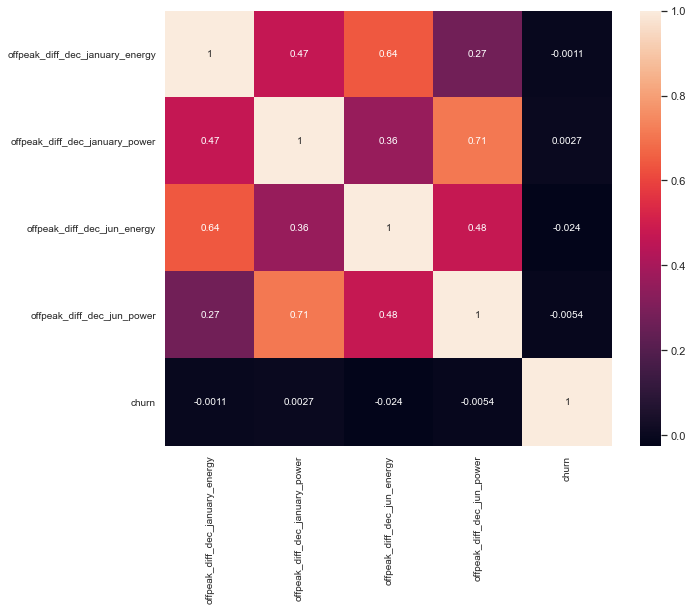

In [468]:
diff_analysis=pd.merge(diff, df[['id', 'churn']], on='id')
corr = diff_analysis.corr()
# Plot correlation
plt.figure(figsize=(10,8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The correlation with churn is very low.

### Transforming dates into months
* months_activ = Number of months active until reference date (Jan 2016)
* months_to_end = Number of months of the contract left until reference date (Jan 2016)
* months_modif_prod = Number of months since last modification until reference date (Jan 2016)
*months_renewal = Number of months since last renewal until reference date (Jan 2016)

*** This part(transforming dates into months) is from the BCG solution from forage (https://www.theforage.com/virtual-internships/prototype/Tcz8gTtprzAS4xSoK/GAMMA-Virtual-Experience-Program?ref=NorEhdj87k7nLnwK2)

In [469]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [470]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

1. How long a customer has been active may reveal the loyalty to some extent, so more active months, higher retention probability. 

2. Clients coming toward the end of contract probably look for better deals, while clinets just joined may have a period to leave if they're not satisfied and for clients in the middle contract, they may be charged if they wanted to leave, deterring clients from churning mid-way through their agreement. So, I think months to end will be an interesting feature because it may reveal patterns and behaviours about timing of churn.

3. If a client has made recent updates to their contract, they are more likely to be satisfied or at least they have received a level of customer service to update or change their existing services. This may be a positive sign, they are an engaged customer, and so I believe months_modif_prod will be an interesting feature to include because it shows the degree of how 'engaged' a client is.

4. Finally the number of months since a client last renewed a contract I believe will be an interesting feature because once again, it shows the degree to which that client is engaged. It also goes a step further than just engagement, it shows a level of commitment if a client renews their contract. For this reason, I believe months_renewal will be a good feature to include.

In [471]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,...,12.218665,8.145777,42.629663,12.311304,8.182687,1,30,5,2,6
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,...,0.000000,0.000000,44.592310,0.000000,0.000000,0,76,7,76,4
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,...,0.000000,0.000000,44.612508,0.088409,0.000000,0,68,3,68,8
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,...,0.000000,0.000000,44.593296,0.000000,0.000000,0,69,2,69,9
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,...,24.437330,16.291555,40.848791,24.539003,16.365274,0,71,2,71,9


### Transforming Boolean data

In [472]:
# has_gas
# transform this column from being categorical to being a binary flag
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081887


### Correlations

In [473]:
correlation = df.corr()

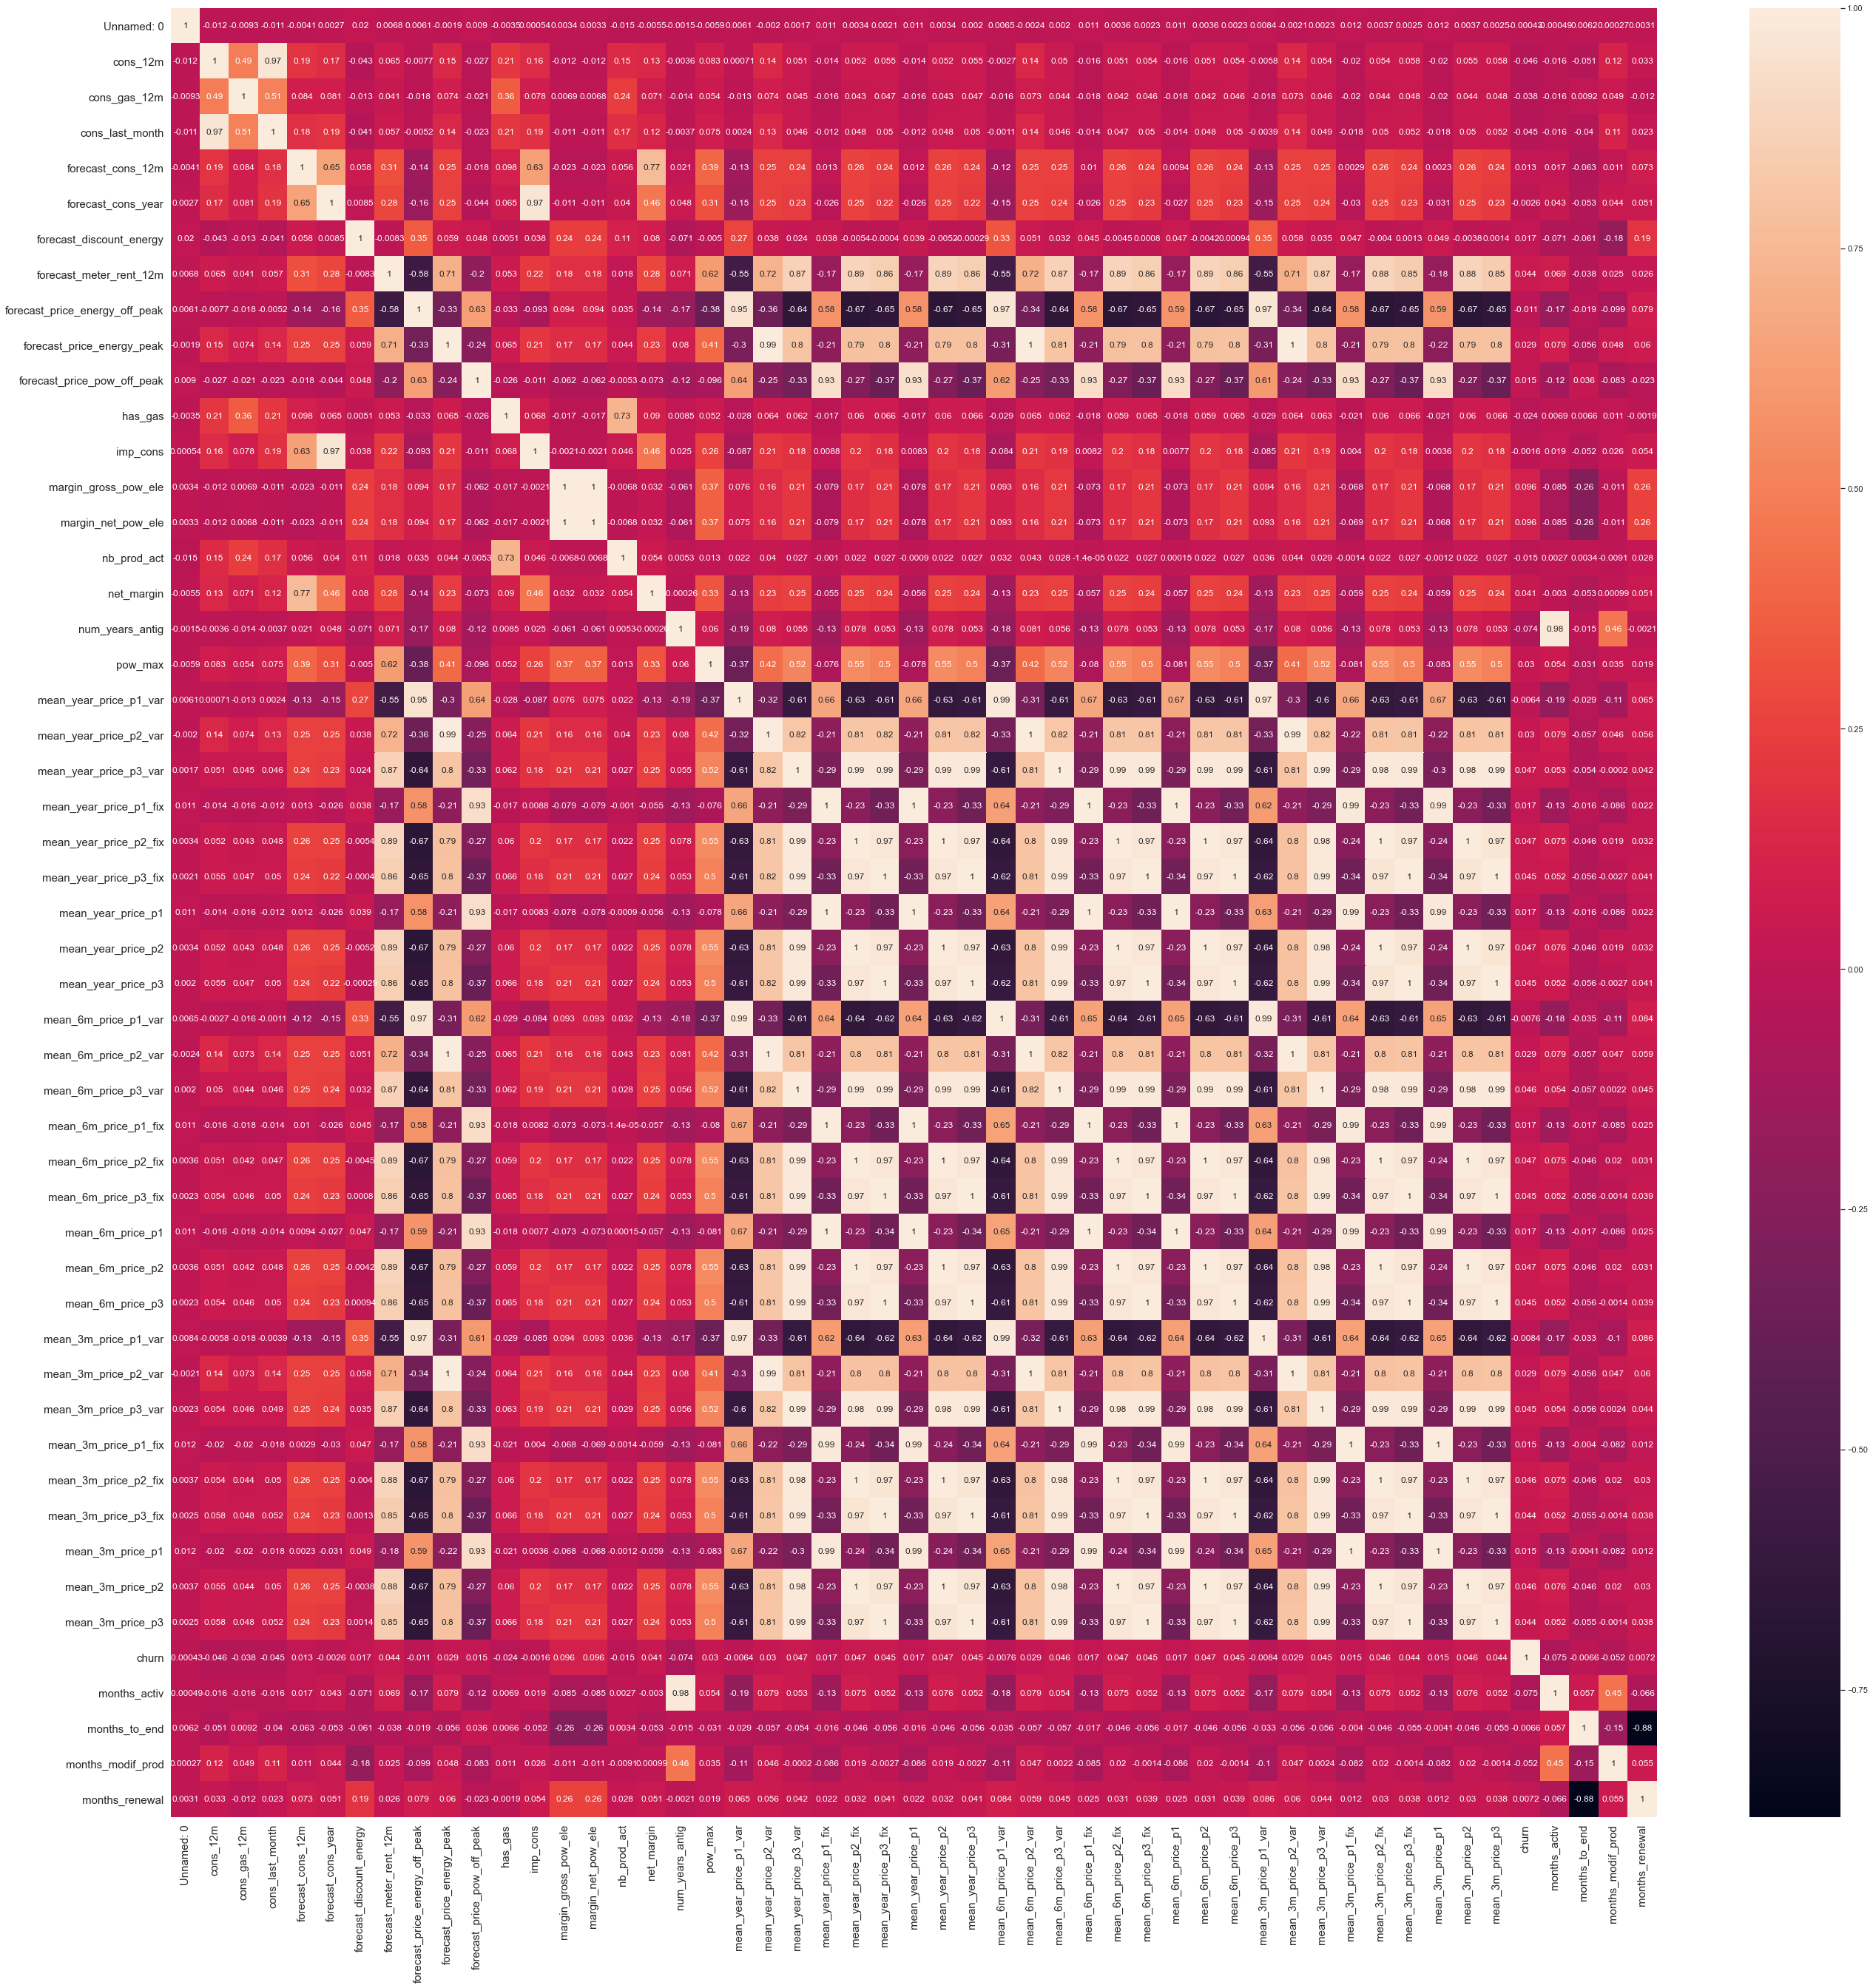

In [474]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [475]:
dr1=correlation[(correlation['forecast_price_energy_off_peak']>0.7) | (correlation['forecast_price_energy_off_peak']<-0.7)].index.tolist()[1:]

In [476]:
dr2=correlation[(correlation['mean_year_price_p3_var']>0.7) | (correlation['mean_year_price_p3_var']<-0.7)].index.tolist()
dr2.remove('mean_year_price_p3_var')

In [477]:
dr3=correlation[(correlation['forecast_price_pow_off_peak']>0.7) | (correlation['forecast_price_pow_off_peak']<-0.7)].index.tolist()
dr3.remove('forecast_price_pow_off_peak')

In [478]:
# Drop one of those highly-correlated column pairs. 
drop_columns = []
[drop_columns.append(x) for x in dr1 if x not in drop_columns]
[drop_columns.append(x) for x in dr2 if x not in drop_columns]
[drop_columns.append(x) for x in dr3 if x not in drop_columns]
# drop_columns = dr1+dr2+dr3
df = df.drop(columns=drop_columns)
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_price_energy_off_peak,...,net_margin,num_years_antig,origin_up,pow_max,mean_year_price_p3_var,churn,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,0.114481,...,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.066530,1,30,5,2,6
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,0.145711,...,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.000000,0,76,7,76,4
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,0.165794,...,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.000000,0,68,3,68,8
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,0.146694,...,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0.000000,0,69,2,69,9
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,0.116900,...,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0.072865,0,71,2,71,9


In [479]:
correlation2 = df.corr()

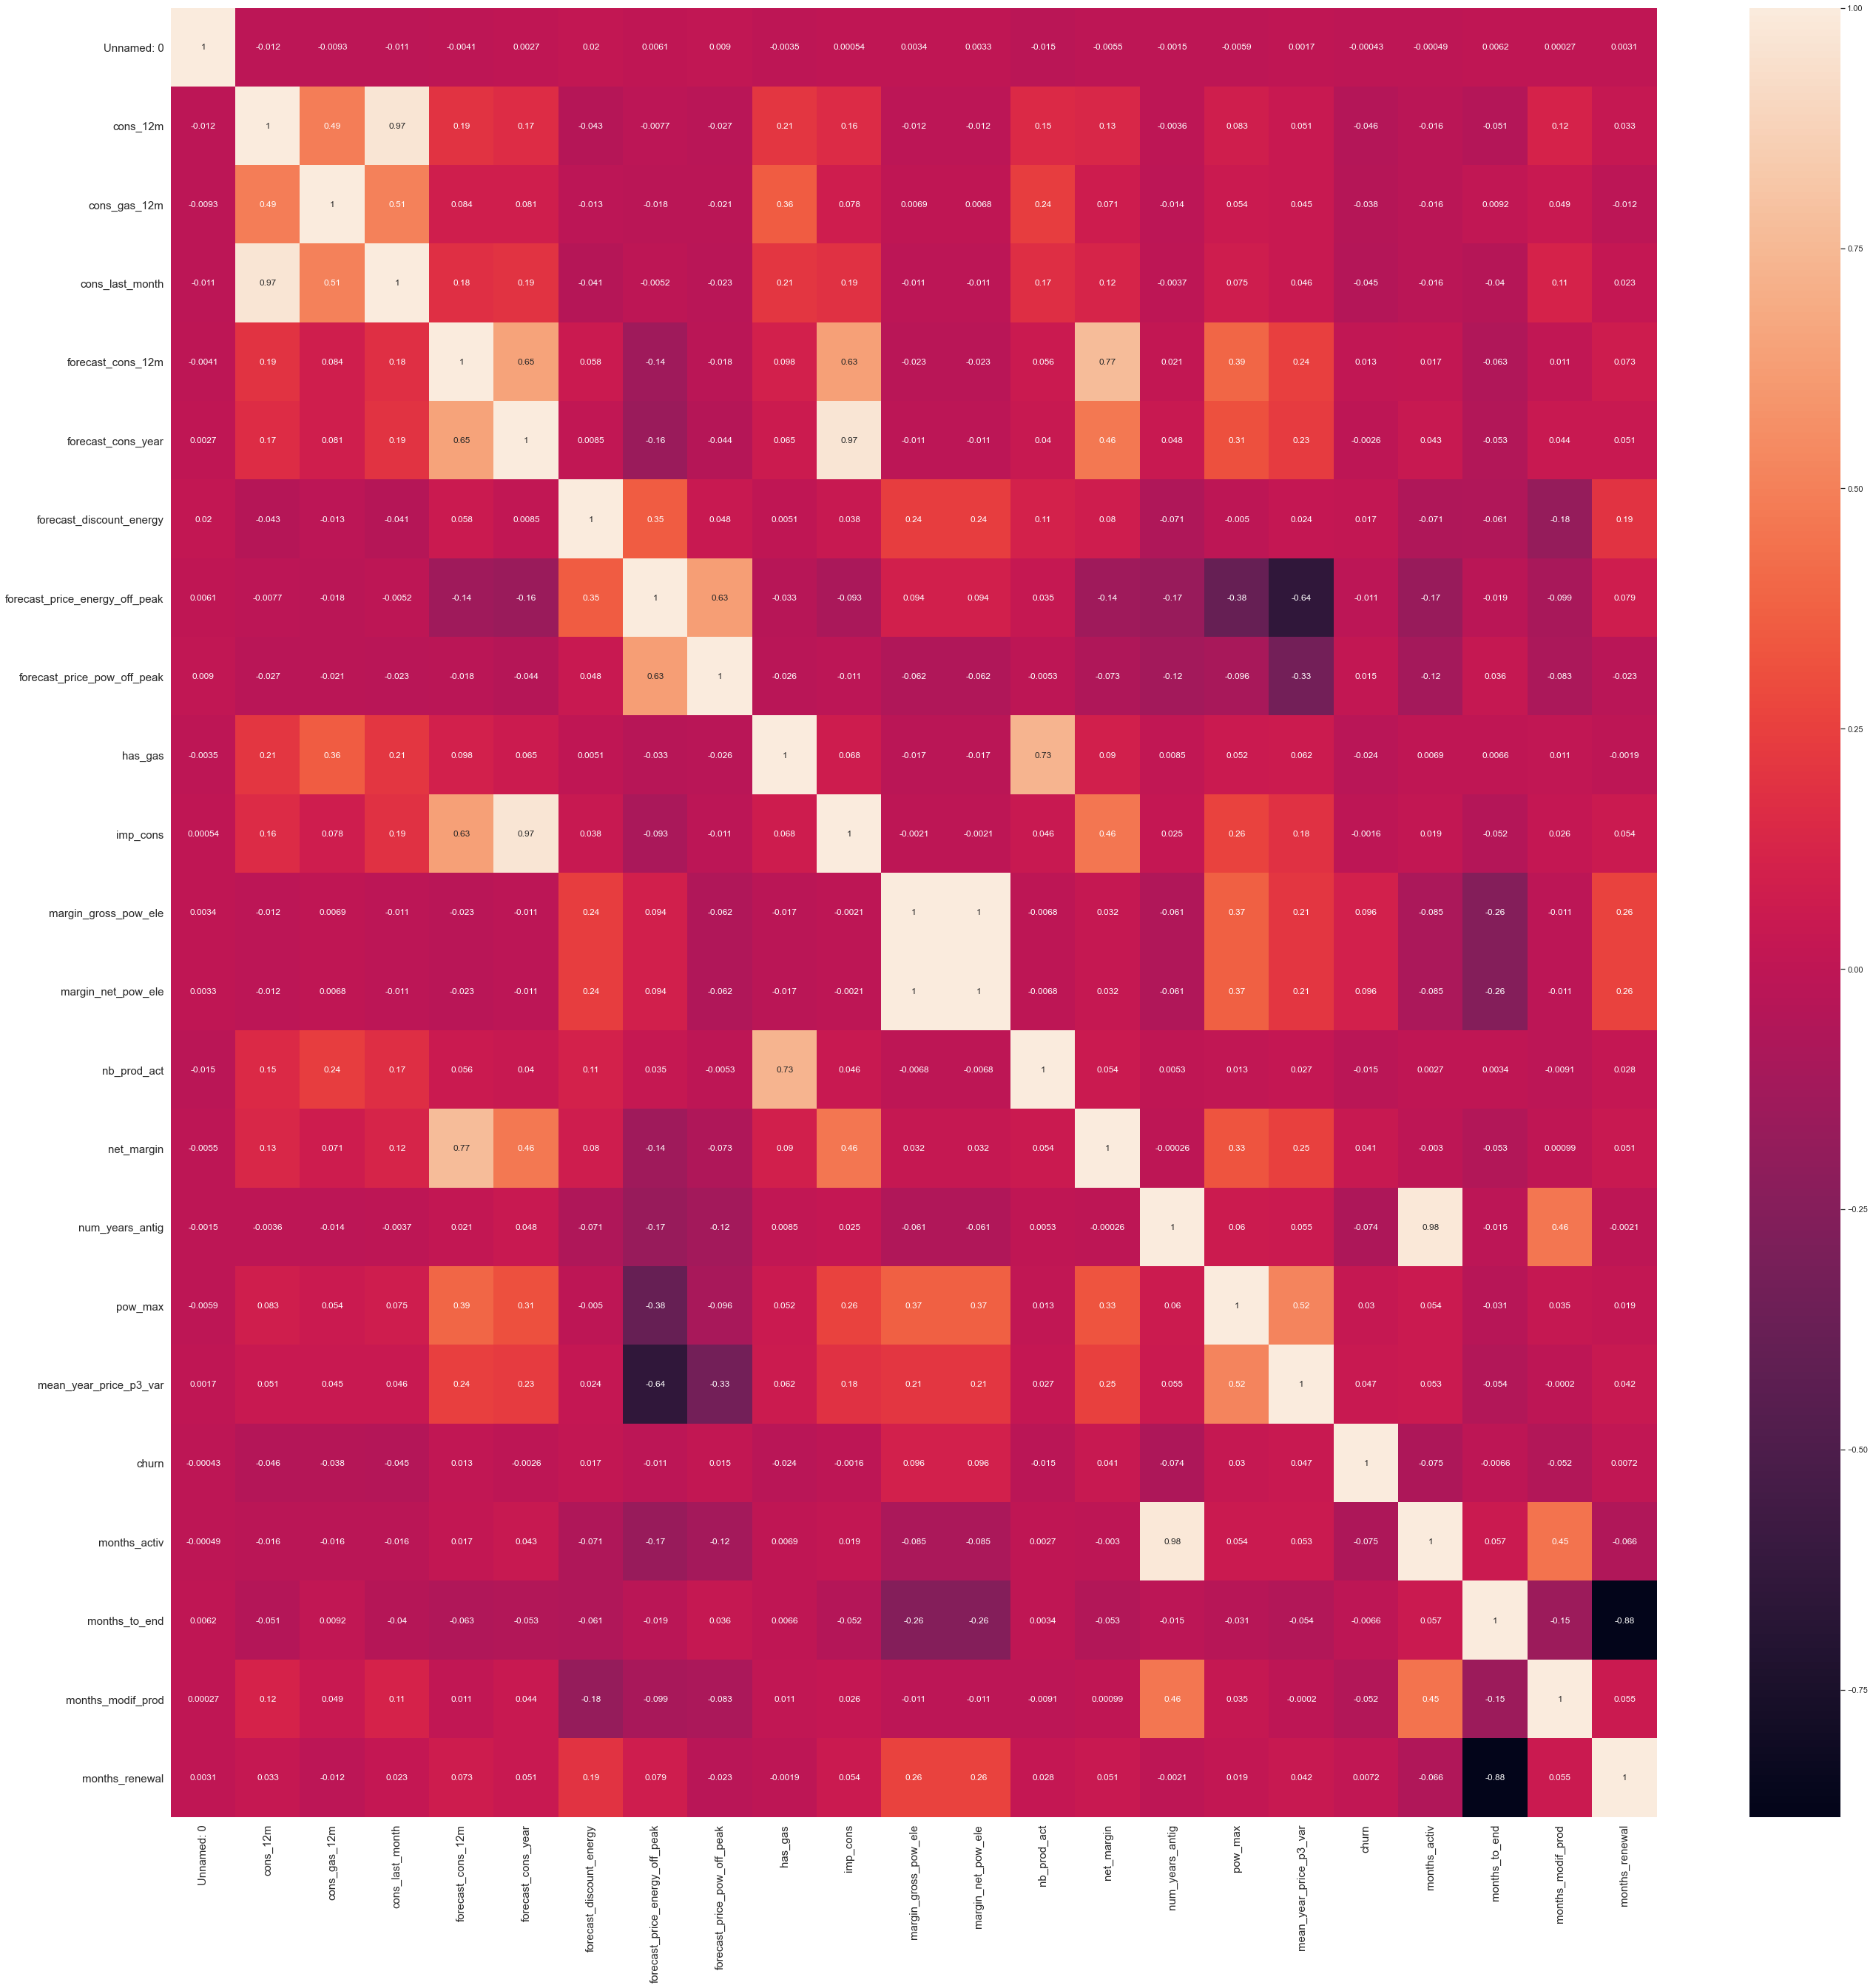

In [480]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation2, 
    xticklabels=correlation2.columns.values,
    yticklabels=correlation2.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

---

## 4. Modelling

### 4.1 Data preprocessing

In [481]:
model_df=pd.merge(df, diff, on='id')
# model_df['churn']=model_df['churn'].astype('category')
model_df.drop('Unnamed: 0', axis=1, inplace=True)

In [482]:
# Encode the object and datetime columns
le = preprocessing.LabelEncoder()
for column_name in model_df.columns:
        if model_df[column_name].dtype == object or model_df[column_name].dtype == 'datetime64[ns]':
            model_df[column_name] = le.fit_transform(model_df[column_name])
        else:
            pass

In [483]:
X=model_df.drop(columns= ['id','churn'])  # Features
y=model_df['churn']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


In [484]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14595, 27)
(14595,)
(10216, 27)
(10216,)
(4379, 27)
(4379,)


### 4.2 Model training

In [485]:
#Create a Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000)

### 4.3 Model evaluation

In [486]:
y_pred=clf.predict(X_test)
y_probs = clf.predict_proba(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

In [487]:
# fpr and tpr for the claasifier
fpr, tpr, thresh = metrics.roc_curve(y_test, y_probs[:,1], pos_label=1)
auc_score = metrics.roc_auc_score(y_test, y_probs[:,1])
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)

In [488]:
# Model performance
print("Accuracy:",metrics.accuracy_score(y_test, y_pred).round(3))
print("Precision:",metrics.precision_score(y_test, y_pred).round(3))
print('recall:', metrics.recall_score(y_test, y_pred).round(3))
print("roc_auc_score:",auc_score.round(3))

Accuracy: 0.913
Precision: 0.903
recall: 0.069
roc_auc_score: 0.709


Looking at these results there are a few things to point out:

Within the test set about 10% of the rows are churners (churn = 1).

The accuracy and precision score is high, but it does not tell us the whole story.
The recall shows us that the classifier has a very poor ability to identify positive samples.
So overall, we are not able to predict cases where clients do churn correctly. We are identifying high percent of customers as not-churn but acutally they would. 

So the feature engineering part may need further dived deep, as well as the model fine-tuning to optimzie the recall score.


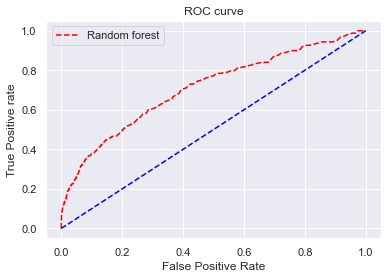

In [489]:
# Plot ROC curve
plt.plot(fpr, tpr, linestyle='--',color='red', label='Random forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

### 4.4 Model understanding

In [490]:
feature_imp = pd.Series(clf.feature_importances_,index=model_df.drop(columns= ['id','churn']).columns).sort_values(ascending=False)

No handles with labels found to put in legend.


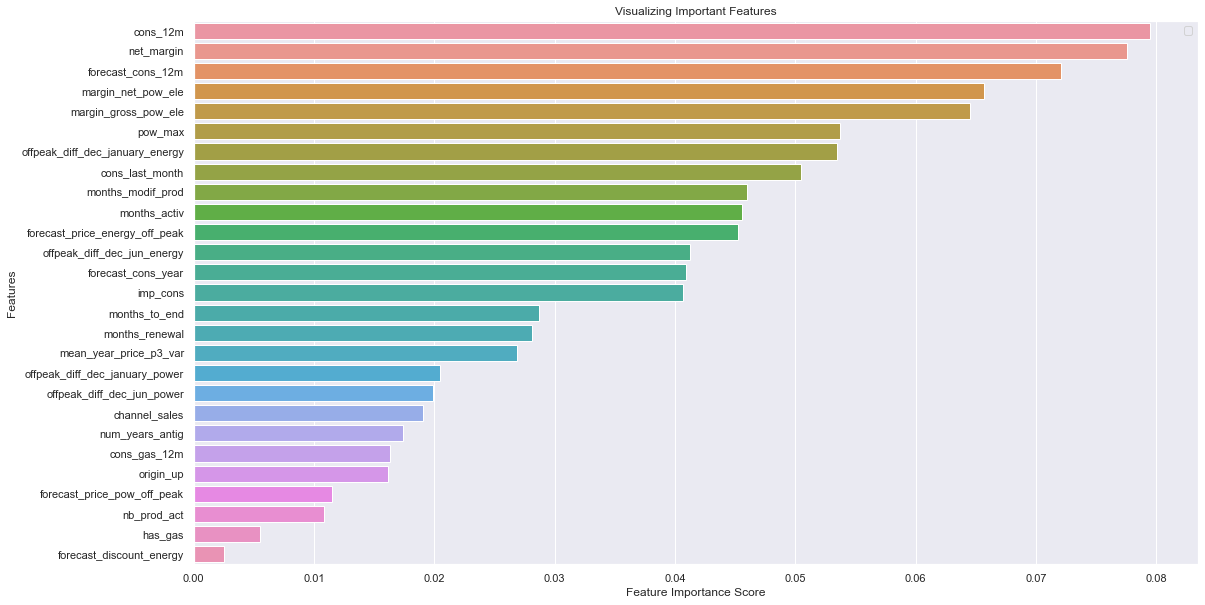

In [491]:
# Creating a bar plot to visualize feature importance
plt.figure(figsize=(18,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

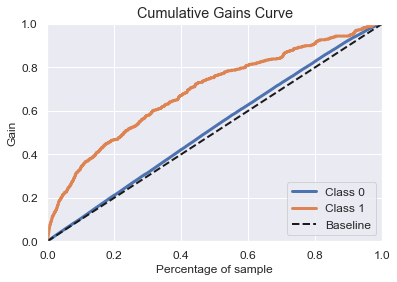

In [492]:
# Cumulative gain curve
skplt.metrics.plot_cumulative_gain(y_test, y_probs)
plt.show()

### Model fine-tuning: Only use the top 15 most important features to train the model

Fewer features also mean less efforts needed to obtain and maintain data.

In [493]:
feature_imp[0:15].index

Index(['cons_12m', 'net_margin', 'forecast_cons_12m', 'margin_net_pow_ele',
       'margin_gross_pow_ele', 'pow_max', 'offpeak_diff_dec_january_energy',
       'cons_last_month', 'months_modif_prod', 'months_activ',
       'forecast_price_energy_off_peak', 'offpeak_diff_dec_jun_energy',
       'forecast_cons_year', 'imp_cons', 'months_to_end'],
      dtype='object')

In [494]:
X=model_df[list(feature_imp[0:15].index)] # Features
y=model_df['churn']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [495]:
#Create a Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
y_probs = clf.predict_proba(X_test)

In [496]:
fpr, tpr, thresh = metrics.roc_curve(y_test, y_probs[:,1], pos_label=1)
auc_score = metrics.roc_auc_score(y_test, y_probs[:,1])
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)

In [497]:
# Model performance
print("Accuracy:",metrics.accuracy_score(y_test, y_pred).round(3))
print("Precision:",metrics.precision_score(y_test, y_pred).round(3))
print('recall:', metrics.recall_score(y_test, y_pred).round(3))
print("roc_auc_score:",auc_score.round(3))

Accuracy: 0.902
Precision: 0.833
recall: 0.045
roc_auc_score: 0.675


In [498]:
feature_imp = pd.Series(clf.feature_importances_,index=list(feature_imp[0:15].index)).sort_values(ascending=False)

No handles with labels found to put in legend.


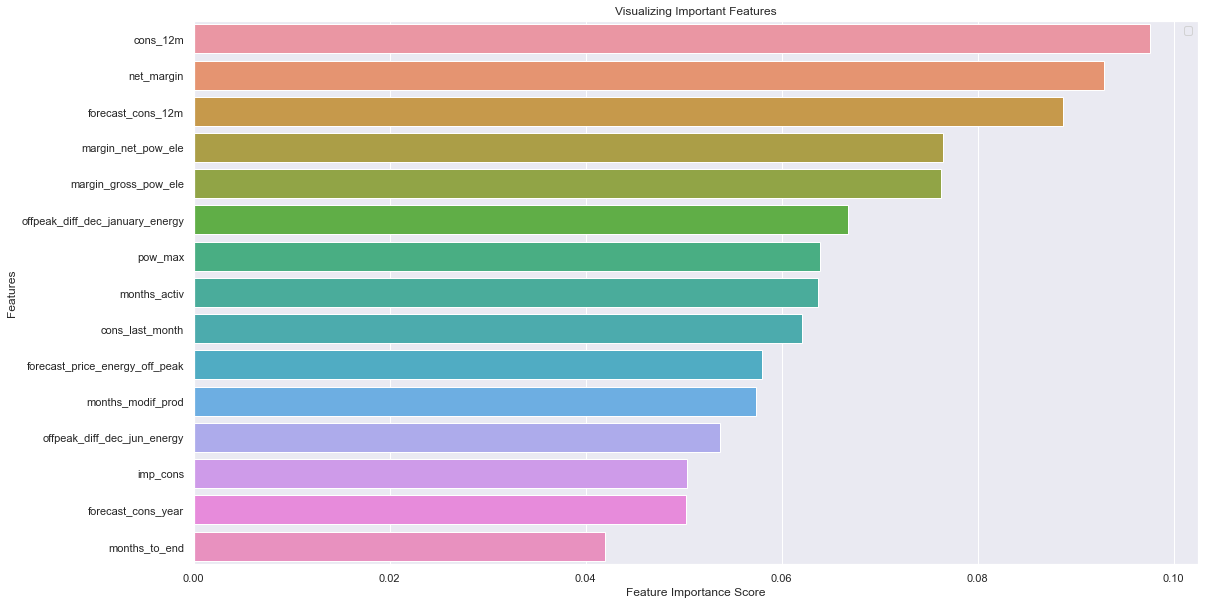

In [499]:
# Creating a bar plot to visualize feature importance
plt.figure(figsize=(18,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

From this chart, we can have below observations:

* Consumption over 12 months and net margin is top drivers for churn in this model
* Forecasted electricity consumption for next 12 months is also an influential driver
* Price sensitivity features are scattered around but are not the main driver for a customer churning

Recall the original hypothesis:

`Is churn driven by the customers' price sensitivity?`

Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.